In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
import torch.nn as nn
import re
from tqdm.notebook import trange, tqdm
from torch.utils.data import DataLoader
import transformers

In [2]:
test = pd.read_csv('Data/test.csv')
train = pd.read_csv('Data/train.csv')


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.drop(['keyword','location'],axis=1,inplace=True)
test.drop(['keyword','location'],axis=1,inplace=True)

In [5]:
print(train.info())
print()
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB
None


In [6]:
train.isnull().sum()

id        0
text      0
target    0
dtype: int64

In [7]:
test.isnull().sum()

id      0
text    0
dtype: int64

In [8]:
train['Length']=train['text'].apply(lambda x: len(x.split(' ')))
test['Length']=test['text'].apply(lambda x: len(x))

In [9]:
train

,id,text,target,Length
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,11
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,20
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8
7611,10872,Police investigating after an e-bike collided ...,1,19


<Figure size 504x504 with 0 Axes>

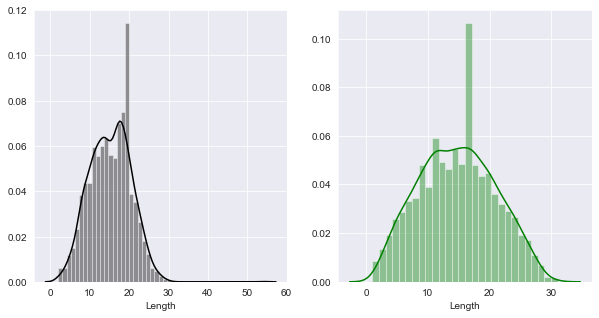

In [10]:
plt.figure(figsize=(7,7))
sns.set_style('darkgrid')
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(train[train['target']==1]['Length'],ax=ax1,color='black')
sns.distplot(train[train['target']==0]['Length'],ax=ax2,color='green')

In [22]:
TOKENS_MAX_LENGTH = 64
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 4
EPOCHS = 10

TOKENIZER = transformers.BertTokenizer.from_pretrained("../bert_base_uncased", do_lower_case=True,truncation=True)


In [12]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from num2words import num2words

class GG_Dataset:
    def __init__(self,text,target):
        self.tweet = text
        self.target = target
#         self.keyword = keyword
#         self.location = location
        self.tokenizer = TOKENIZER
        self.max_len = TOKENS_MAX_LENGTH
    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self,item):
        tweet = re.sub(r'http\S+', '', self.tweet[item]) ###removes URL from tweets
        tweet = " ".join(str(tweet).split())
        
        
        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,truncation=True
        )
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask" : torch.tensor(mask, dtype=torch.long),
            "token_type_ids" : torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(self.target[item], dtype=torch.float),
#             "orig_tweet" : self.tweet[item],
#             "orig_keyword" : self.keyword[item],
#             "orig_location" : self.location[item]
        }

In [13]:
### INITIALIZE BERT
class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained("../bert_base_uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.relu =  nn.ReLU()
        self.linear1 = nn.Linear(768,512)
        self.linear2 = nn.Linear(512,128)
        self.linear3 = nn.Linear(128,1)
        
    def forward(self,ids,mask,token_type_ids):
        sequence_output,pooled_output = self.bert(ids,attention_mask=mask,token_type_ids=token_type_ids) 
        ## pooled_output shape(batch_size,768)
        
        bert_output = self.bert_drop(pooled_output)
        relu_output=self.relu(bert_output)
        
        linear_output1=self.linear1(relu_output) ###takes 768 dim vectors
        ## linear_output1 shape (batch_size,512)
        linear_output2 = self.linear2(linear_output1)
        ## linear_output2 shape (batch_size,128)
        final_output = self.linear3(linear_output2)
        ## linear_output2 shape (batch_size,1)        
        return final_output

In [14]:
def loss_function(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [15]:
def train_fn(data_loader,model,optimizer,device,scheduler):
    model.train()
    losses = AverageMeter()
    tk0=tqdm(data_loader,total=len(data_loader))
  
    for abi,row in enumerate(tk0):
        ids = row["ids"]
        token_type_ids = row["token_type_ids"]
        mask = row["mask"]
        targets = row["targets"]
        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(ids=ids,mask=mask,token_type_ids=token_type_ids)
        loss = loss_function(outputs,targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.update(loss.item(),ids.size(0))
        tk0.set_postfix(loss=losses.avg)

In [16]:
def eval_fn(data_loader, model, device):
    model.eval()
    final_targets = []
    final_output = []
    
    with torch.no_grad():
        for idx,row in tqdm(enumerate(data_loader),total=len(data_loader)):
            ids = row["ids"]
            token_type_ids = row["token_type_ids"]
            mask = row["mask"]
            targets = row["targets"]
            
            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device,dtype=torch.long)
            mask = mask.to(device,dtype=torch.long)
            targets = targets.to(device,dtype=torch.float)
            
            outputs = model(ids=ids,mask=mask,token_type_ids=token_type_ids)
            final_targets.extend(targets.cpu().detach().numpy().tolist())
            final_output.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        return final_output,final_targets

In [17]:
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

df_train, df_valid = model_selection.train_test_split(train, test_size=0.1, random_state=42, stratify=train.target.values)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = GG_Dataset(#keyword=df_train.keyword.values,
                       #location=df_train.location.values,
                       text=df_train.text.values,
                       target=df_train.target.values)
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,
                                                )


valid_dataset = GG_Dataset(#keyword=df_valid.keyword.values,
                       #location=df_valid.location.values,
                       text=df_valid.text.values,
                       target=df_valid.target.values)
valid_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,)


In [18]:
device = torch.device("cuda")
model = BERTBaseUncased()
model.to(device)



BERTBaseUncased(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [19]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{
        "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],"weight_decay": 0.001,},
    {   "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],"weight_decay": 0.0,}]
optimizer = AdamW(optimizer_parameters, lr=2e-5)


In [20]:
num_training_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=num_training_steps)

In [23]:
best_accuracy=0
for ephoch in range(EPOCHS):
    train_fn(train_data_loader,model,optimizer,device,scheduler)
    outputs, targets = eval_fn(valid_data_loader,model,device)
    outputs = np.array(outputs)>=0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    print(f"Accuracy Score = {accuracy} for Epoch = {ephoch} ")
    if accuracy > best_accuracy:
            torch.save(model.state_dict(), "model_disaster_Tweets.bin")
            best_accuracy = accuracy


Accuracy Score = 0.8543307086614174



Accuracy Score = 0.8307086614173228



Accuracy Score = 0.8307086614173228



Accuracy Score = 0.8372703412073491



Accuracy Score = 0.8254593175853019



Accuracy Score = 0.7965879265091863



Accuracy Score = 0.8097112860892388



Accuracy Score = 0.7874015748031497



Accuracy Score = 0.8188976377952756



Accuracy Score = 0.7965879265091863
